# DPO Fine-Tuning — CodeLlama-7B

| Property | Value |
|---|---|
| **Base model** | `codellama/CodeLlama-7b-hf` |
| **Adaptation** | LoRA (r = 64, α = 64, bf16) |
| **GPU** | H100 80 GB |
| **Pipeline** | SFT → DPO |
| **Dataset** | [`t4gandhi/llm_corrected_humaneval_dataset`](https://huggingface.co/datasets/t4gandhi/llm_corrected_humaneval_dataset) |
| **Evaluation** | Pairwise preference accuracy on held-out test set (5-pass) |

In [1]:
%%capture
!pip install --upgrade --force-reinstall --no-cache-dir --no-deps unsloth unsloth_zoo
from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install --no-deps {xformers} "trl>=0.12,<0.14" peft accelerate triton bitsandbytes
!pip install --no-deps "transformers>=4.50.3"
# restart runtime, then run from the next cell

In [2]:
import os, gc, warnings, torch
os.environ["WANDB_MODE"] = "disabled"
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "300"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
warnings.filterwarnings("ignore")

# ── Precision configuration ──────────────────────────────────────────
# TF32 on Ampere+ (compute capability >= 8.0): ~2x faster, same convergence.
# Falls back to bf16 if TF32 unavailable, then fp16 as last resort.
if torch.cuda.is_available():
    _cc = torch.cuda.get_device_capability()
    USE_TF32 = _cc[0] >= 8                         # Ampere / Hopper / Ada
    USE_BF16 = torch.cuda.is_bf16_supported()
    USE_FP16 = not USE_BF16
    if USE_TF32:
        torch.set_float32_matmul_precision("high")
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32  = True
    torch.backends.cudnn.benchmark = True           # auto-tune conv kernels
    _vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU : {torch.cuda.get_device_name(0)} | VRAM {_vram:.0f} GB | "
          f"CC {_cc[0]}.{_cc[1]} | TF32 {'ON' if USE_TF32 else 'off'} | "
          f"{'bf16' if USE_BF16 else 'fp16'}")
else:
    USE_TF32 = False; USE_BF16 = False; USE_FP16 = True

from huggingface_hub import login
from google.colab import userdata
login(token=userdata.get("HF_TOKEN"))

import transformers.models.auto.modeling_auto as _auto_mod  # trl compat
if not hasattr(_auto_mod, "MODEL_FOR_VISION_2_SEQ_MAPPING_NAMES"):
    _auto_mod.MODEL_FOR_VISION_2_SEQ_MAPPING_NAMES = {}

MODEL_NAME     = "codellama/CodeLlama-7b-hf"
MAX_SEQ_LENGTH = 2048
LOAD_IN_4BIT   = False
SAMPLE_SIZE    = None
RUN_SFT        = True
RUN_DPO        = True
SEED           = 3407
NUM_PROC       = 8
DL_WORKERS     = 4

BATCH_SIZE     = 8
GRAD_ACCUM     = 2    # eff. 16
SFT_EPOCHS     = 1
DPO_EPOCHS     = 15
DPO_LR         = 2e-5
PATIENCE       = 5
EVAL_PASSES    = 5

DPO_BATCH_SIZE = 4
DPO_GRAD_ACCUM = 4    # eff. 16
DPO_MAX_LEN    = 2048
DPO_PROMPT_LEN = 1024

# GPU-adaptive: override batch sizes based on available VRAM
if torch.cuda.is_available():
    _vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {torch.cuda.get_device_name(0)} | VRAM: {_vram:.0f} GB")
    if _vram >= 70:   BATCH_SIZE, GRAD_ACCUM, DPO_BATCH_SIZE, DPO_GRAD_ACCUM = 8, 2, 4, 4
    elif _vram >= 35: BATCH_SIZE, GRAD_ACCUM, DPO_BATCH_SIZE, DPO_GRAD_ACCUM = 4, 4, 2, 8
    elif _vram >= 20: BATCH_SIZE, GRAD_ACCUM, DPO_BATCH_SIZE, DPO_GRAD_ACCUM = 2, 8, 1, 16
    else:             BATCH_SIZE, GRAD_ACCUM, DPO_BATCH_SIZE, DPO_GRAD_ACCUM = 2, 8, 1, 16
    print(f"SFT batch: {BATCH_SIZE}×{GRAD_ACCUM} (eff {BATCH_SIZE*GRAD_ACCUM}) | "
          f"DPO batch: {DPO_BATCH_SIZE}×{DPO_GRAD_ACCUM} (eff {DPO_BATCH_SIZE*DPO_GRAD_ACCUM})")

GPU : NVIDIA H100 80GB HBM3 | VRAM 85 GB | CC 9.0 | TF32 ON | bf16
GPU: NVIDIA H100 80GB HBM3 | VRAM: 85 GB
SFT batch: 8×2 (eff 16) | DPO batch: 4×4 (eff 16)


In [3]:
import gc, time, json, numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd, torch, matplotlib.pyplot as plt, seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict

FIGURE_DIR = Path("figures"); FIGURE_DIR.mkdir(exist_ok=True)
plt.rcParams.update({"figure.dpi": 150, "savefig.dpi": 300,
                      "savefig.bbox": "tight", "font.size": 11})
sns.set_theme(style="whitegrid", font_scale=1.1,
              rc={"axes.spines.top": False, "axes.spines.right": False})

def gpu_mem():
    if not torch.cuda.is_available(): return "no GPU"
    return f"{torch.cuda.memory_allocated()/1e9:.1f} GB (peak {torch.cuda.max_memory_allocated()/1e9:.1f} GB)"

def clear_gpu():
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

def apply_chat_template(example, tokenizer=None, task="sft"):
    if task in ("sft", "generation"):
        msgs = example["messages"]
        example["text"] = (f"<s>[INST] <<SYS>>\n\n<</SYS>>\n\n"
                           f"{msgs[0]['content']}\n[/INST] {msgs[1]['content']}</s>")
    elif task == "dpo":
        user = example["chosen"][0]["content"]
        example["text_prompt"]   = f"<s>[INST] <<SYS>>\n\n<</SYS>>\n\n{user}\n[/INST]"
        example["text_chosen"]   = f" {example['chosen'][1]['content']}</s>"
        example["text_rejected"] = f" {example['rejected'][1]['content']}</s>"
    return example

INSTRUCTION = (
    "<instruction>\n  <bullets>\n"
    "    <bullet>The following buggy code is a wrong implementation that contains one or more bugs.</bullet>\n"
    "    <bullet>Firstly, find all of the bugs within the buggy code. Make sure to quotate each part of the buggy code that contains a bug.</bullet>\n"
    "    <bullet>Afterwards, for each of the bugs, describe the issue with each part of the buggy code with the bug, and outline how to fix the issue.</bullet>\n"
    "    <bullet>Make sure your answer covers (1) all of the existing bugs, (2) do not hallucinate non-existing bugs, and (3) be concise as possible.</bullet>\n"
    "    <bullet>IMPORTANT!: While abiding by the above instructions, keep your answer as brief as possible.</bullet>\n"
    "  </bullets>\n</instruction>"
)

HF_DATASET = "t4gandhi/llm_corrected_humaneval_dataset"

def _parse_score(val):
    if val is None or (isinstance(val, float) and pd.isna(val)): return 0
    s = str(val).strip()
    return int(s[0]) if s and s != "nan" else 0

def make_datasets(sample_size=None):
    """Build SFT and DPO splits from the HF preference dataset."""
    print(f"Loading {HF_DATASET}")
    raw = load_dataset(HF_DATASET)
    df_tr, df_te = pd.DataFrame(raw["train"]), pd.DataFrame(raw["test"])
    print(f"  Raw — train: {len(df_tr)}, test: {len(df_te)}")

    REQUIRED = {"prompt", "result", "score_s1_rd1", "score_s6_custom",
                "analysis_rd1", "analysis_custom"}
    assert not (REQUIRED - set(df_tr.columns)), f"Missing columns: {REQUIRED - set(df_tr.columns)}"

    if sample_size:
        df_tr = df_tr.sample(min(sample_size, len(df_tr)), random_state=SEED).reset_index(drop=True)
        df_te = df_te.sample(min(sample_size//4, len(df_te)), random_state=SEED).reset_index(drop=True)

    PREFIXES = [f"score_s{i}_" for i in range(1, 7)]
    ROUNDS = ["rd1", "rd2", "rd3", "custom"]
    PAIRS  = [("rd1","rd2"),("rd1","rd3"),("rd1","custom"),
              ("rd2","rd3"),("rd2","custom"),("rd3","custom")]

    def _indent(s): return "\n".join("    " + l for l in s.splitlines())

    def _build(df, split):
        sft, dpo, skipped = [], [], 0
        for _, row in df.iterrows():
            code = "<buggy_code>\n" + (row["prompt"] + _indent(row["result"])).strip("\n") + "\n</buggy_code>"
            instr = INSTRUCTION + "\n" + code
            info = {}
            for rd in ROUNDS:
                sc = sum(_parse_score(row.get(p+rd)) for p in PREFIXES) / 42
                txt = row.get("analysis_"+rd, "")
                if txt is None or (isinstance(txt, float) and pd.isna(txt)): txt = ""
                info[rd] = {"analysis": str(txt), "score": sc}
            for r1, r2 in PAIRS:
                if info[r1]["score"] == info[r2]["score"]: continue
                b = r1 if info[r1]["score"] > info[r2]["score"] else r2
                w = r2 if b == r1 else r1
                if not info[b]["analysis"].strip() or not info[w]["analysis"].strip():
                    skipped += 1; continue
                sft.append({"messages": [
                    {"content": instr, "role": "user"},
                    {"content": info[b]["analysis"], "role": "assistant"}]})
                dpo.append({"prompt": instr,
                    "chosen":   [{"content": instr, "role": "user"},
                                 {"content": info[b]["analysis"], "role": "assistant"}],
                    "rejected": [{"content": instr, "role": "user"},
                                 {"content": info[w]["analysis"], "role": "assistant"}],
                    "metadata": [{"chosen": b, "rejected": w}]})
        if skipped: print(f"  ⚠ {split}: skipped {skipped} pairs (empty analysis)")
        return sft, dpo

    s_tr, d_tr = _build(df_tr, "train")
    s_te, d_te = _build(df_te, "test")

    ds_sft = DatasetDict({"train": Dataset.from_pandas(pd.DataFrame(s_tr)),
                           "test":  Dataset.from_pandas(pd.DataFrame(s_te))})
    ds_dpo = DatasetDict({"train": Dataset.from_pandas(pd.DataFrame(d_tr)),
                           "test":  Dataset.from_pandas(pd.DataFrame(d_te))})

    print(f"  SFT — train: {len(s_tr)}, test: {len(s_te)}")
    print(f"  DPO — train: {len(d_tr)}, test: {len(d_te)}")
    return ds_sft, ds_dpo

def format_sft(ds, tok):
    cols = list(ds["train"].features)
    return ds.map(apply_chat_template, fn_kwargs={"task": "sft"},
                  num_proc=NUM_PROC, remove_columns=cols)

def format_dpo(ds, tok):
    cols = list(ds["train"].features)
    fmt = ds.map(apply_chat_template, fn_kwargs={"task": "dpo"},
                 num_proc=NUM_PROC, remove_columns=cols)
    return fmt.rename_columns({"text_prompt": "prompt",
                               "text_chosen": "chosen", "text_rejected": "rejected"})

def _score_completion(model, tokenizer, prompt_text, completion_text, device):
    """Length-normalised conditional log-prob of the completion."""
    full_enc = tokenizer(prompt_text + completion_text, return_tensors="pt",
                         truncation=True, max_length=MAX_SEQ_LENGTH).to(device)
    prompt_len = tokenizer(prompt_text, return_tensors="pt",
                           truncation=True, max_length=MAX_SEQ_LENGTH).input_ids.shape[1]

    with torch.no_grad():
        logits = model(**full_enc).logits

    if prompt_len >= full_enc.input_ids.shape[1]:
        return float("-inf")

    comp_logits = logits[:, prompt_len - 1:-1, :]
    comp_labels = full_enc.input_ids[:, prompt_len:]
    log_probs = torch.nn.functional.log_softmax(comp_logits, dim=-1)
    return log_probs.gather(-1, comp_labels.unsqueeze(-1)).squeeze(-1).mean().item()

def run_eval(model, tokenizer, dpo_raw_dataset, max_items=None, no_iter=1):
    """Pairwise preference accuracy and mean margin (multi-pass)."""
    was_training = model.training; model.eval()
    device = next(model.parameters()).device
    N = len(dpo_raw_dataset) if max_items is None else min(max_items, len(dpo_raw_dataset))
    total_correct, pass_accs, margins = 0, [], []

    for it in range(no_iter):
        correct = 0
        for i in tqdm(range(N), desc=f"Eval {it+1}/{no_iter}", leave=False):
            item = dpo_raw_dataset[i]
            fmt = apply_chat_template(
                {"chosen": item["chosen"], "rejected": item["rejected"]}, task="dpo")
            r_ch = _score_completion(model, tokenizer, fmt["text_prompt"], fmt["text_chosen"], device)
            r_re = _score_completion(model, tokenizer, fmt["text_prompt"], fmt["text_rejected"], device)
            margins.append(r_ch - r_re)
            if r_ch > r_re:
                correct += 1

        pass_accs.append(correct / max(1, N))
        total_correct += correct

    if was_training: model.train()
    mean_acc = total_correct / max(1, no_iter * N)
    mean_margin = float(np.mean(margins))
    return mean_acc, pass_accs, mean_margin

_PAL = {"Baseline": "#95a5a6", "SFT": "#3498db", "DPO": "#27ae60"}


In [4]:
from unsloth import FastLanguageModel

for _attempt in range(3):
    try:
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=MODEL_NAME, max_seq_length=MAX_SEQ_LENGTH,
            dtype=None, load_in_4bit=LOAD_IN_4BIT)
        print(f"Loaded {MODEL_NAME}")
        break
    except Exception as e:
        if _attempt < 2:
            print(f"Attempt {_attempt+1} failed ({e.__class__.__name__}), retrying...")
            import time; time.sleep(10)
        else:
            raise

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.alignprop_trainer: Failed to import trl.trainer.alignprop_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
/usr/local/lib/python3.12/dist-packages/xformers/flash_attn_3/_C.so: undefined symbol: torch_list_push_back
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following 

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

Unsloth: Will load unsloth/codellama-7b as a legacy tokenizer.


Loaded codellama/CodeLlama-7b-hf


In [5]:
ds_sft, ds_dpo = make_datasets(sample_size=SAMPLE_SIZE)
sft_fmt = format_sft(ds_sft, tokenizer)
dpo_fmt = format_dpo(ds_dpo, tokenizer)

assert len(sft_fmt["train"]) > 0 and len(dpo_fmt["train"]) > 0, "Empty dataset"
assert "text" in sft_fmt["train"].features and "prompt" in dpo_fmt["train"].features

print(f"\nSFT  {len(sft_fmt['train']):>5} train / {len(sft_fmt['test']):>4} test")
print(f"DPO  {len(dpo_fmt['train']):>5} train / {len(dpo_fmt['test']):>4} test")

Loading t4gandhi/llm_corrected_humaneval_dataset


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/82.3k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/35.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


  Raw — train: 30, test: 6
  ⚠ test: skipped 18 pairs (empty analysis)
  SFT — train: 165, test: 13
  DPO — train: 165, test: 13


Map (num_proc=8):   0%|          | 0/165 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/13 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/165 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/13 [00:00<?, ? examples/s]


SFT    165 train /   13 test
DPO    165 train /   13 test


## Stage 1 — SFT

In [6]:
if RUN_SFT:
    from trl import SFTTrainer, SFTConfig

    model = FastLanguageModel.get_peft_model(model, r=64,
        target_modules=["q_proj","k_proj","v_proj","o_proj",
                        "gate_proj","up_proj","down_proj"],
        lora_alpha=64, lora_dropout=0, bias="none",
        use_gradient_checkpointing="unsloth", random_state=SEED)

    sft_trainer = SFTTrainer(model=model, tokenizer=tokenizer,
        train_dataset=sft_fmt["train"],
        args=SFTConfig(
            dataset_text_field="text", max_seq_length=MAX_SEQ_LENGTH,
            dataset_num_proc=NUM_PROC, packing=False,
            per_device_train_batch_size=BATCH_SIZE,
            gradient_accumulation_steps=GRAD_ACCUM,
            dataloader_num_workers=DL_WORKERS,
            dataloader_pin_memory=True,
            dataloader_prefetch_factor=2,
            warmup_steps=5, num_train_epochs=SFT_EPOCHS,
            learning_rate=2e-4,
            tf32=USE_TF32, fp16=USE_FP16, bf16=USE_BF16,
            logging_steps=10, optim="adamw_8bit",
            weight_decay=0.01, lr_scheduler_type="linear",
            seed=SEED, output_dir="outputs/sft_demo"),
    )

    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    _t0 = time.time()
    sft_trainer.train()
    _sft_dur = time.time() - _t0

    model.save_pretrained("outputs/sft_demo")
    tokenizer.save_pretrained("outputs/sft_demo")
    print(f"SFT done → outputs/sft_demo  ({_sft_dur/60:.1f} min, {gpu_mem()})")
else:
    print("SFT skipped (RUN_SFT=False)")

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/165 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 165 | Num Epochs = 1 | Total steps = 11
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 159,907,840 of 6,898,458,624 (2.32% trained)


Step,Training Loss
10,1.050016


SFT done → outputs/sft_demo  (0.9 min, 14.5 GB (peak 54.4 GB))


## Stage 2 — DPO

In [7]:
# SFT baseline accuracy (before DPO)
# (skip for_inference() here — it would break subsequent DPO training)
if RUN_SFT:
    sft_baseline, _, sft_bl_margin = run_eval(model, tokenizer, ds_dpo["test"],
                                              max_items=min(128, len(ds_dpo["test"])), no_iter=1)
    print(f"SFT baseline accuracy: {sft_baseline * 100:.2f}%  margin: {sft_bl_margin:.4f}")
else:
    sft_baseline, sft_bl_margin = None, None
    print("SFT was skipped — no baseline")

SFT baseline accuracy: 53.85%  margin: 0.0620


In [8]:
if RUN_DPO:
    try: del sft_trainer
    except NameError: pass
    clear_gpu()

    from unsloth import PatchDPOTrainer; PatchDPOTrainer()
    from trl import DPOTrainer, DPOConfig
    from transformers import TrainerCallback

    if not RUN_SFT:
        model = FastLanguageModel.get_peft_model(model, r=64,
            target_modules=["q_proj","k_proj","v_proj","o_proj",
                            "gate_proj","up_proj","down_proj"],
            lora_alpha=64, lora_dropout=0, bias="none",
            use_gradient_checkpointing="unsloth", random_state=SEED)

    # ── Per-epoch preference eval + early stopping callback ───────────
    epoch_log = []

    class _PrefEvalCB(TrainerCallback):
        """Evaluate pairwise preference accuracy after every epoch and
        trigger early stopping when accuracy plateaus."""
        def __init__(self, patience=3):
            self.patience = patience
            self.best_acc, self.best_epoch, self.wait = 0.0, 0, 0
            self._t0 = None

        def on_epoch_begin(self, args, state, control, **kw):
            self._t0 = time.time()

        def on_epoch_end(self, args, state, control, model=None, **kw):
            ep = int(state.epoch)
            acc, pass_accs, margin = run_eval(
                model, tokenizer, ds_dpo["test"], no_iter=EVAL_PASSES)
            _dur = (time.time() - self._t0) / 60

            ckpt = f"outputs/dpo_demo/epoch_{ep}"
            os.makedirs(ckpt, exist_ok=True)
            dpo_trainer.save_model(ckpt)

            tag = ""
            if acc > self.best_acc:
                self.best_acc, self.best_epoch = acc, ep
                self.wait = 0
                dpo_trainer.save_model("outputs/dpo_demo")
                tag = " ★"
            else:
                self.wait += 1

            epoch_log.append({"epoch": ep, "acc": acc, "margin": margin,
                              "pass_accs": pass_accs, "time_min": _dur})
            print(f"  Epoch {ep:>2}/{DPO_EPOCHS}  acc={acc*100:.2f}%  "
                  f"margin={margin:.4f}  {_dur:.1f}min{tag}")

            if self.wait >= self.patience:
                print(f"  Early stop — no improvement for {self.patience} epochs")
                control.should_training_stop = True

    _cb = _PrefEvalCB(patience=PATIENCE)

    dpo_trainer = DPOTrainer(model=model, ref_model=None,
        args=DPOConfig(
            per_device_train_batch_size=DPO_BATCH_SIZE,
            gradient_accumulation_steps=DPO_GRAD_ACCUM,
            dataloader_num_workers=DL_WORKERS,
            dataloader_pin_memory=True,
            dataloader_prefetch_factor=2,
            warmup_ratio=0.05,
            num_train_epochs=DPO_EPOCHS,
            learning_rate=DPO_LR,
            tf32=USE_TF32, fp16=USE_FP16, bf16=USE_BF16,
            logging_steps=1, optim="adamw_8bit",
            weight_decay=0.0,
            max_grad_norm=1.0,
            beta=0.05, max_length=DPO_MAX_LEN, max_prompt_length=DPO_PROMPT_LEN,
            lr_scheduler_type="cosine",
            save_strategy="no",
            seed=42, output_dir="outputs/dpo_demo"),
        train_dataset=dpo_fmt["train"], tokenizer=tokenizer,
        callbacks=[_cb],
    )

    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()
    _dpo_t0 = time.time()
    dpo_trainer.train()
    _dpo_total = time.time() - _dpo_t0

    best_acc, best_epoch = _cb.best_acc, _cb.best_epoch
    print(f"\nBest epoch: {best_epoch} — {best_acc*100:.2f}%")
    print(f"DPO total: {_dpo_total/60:.1f} min | {gpu_mem()}")

    # push to Hub
    HUB_REPO = "t4gandhi/Codellama-7b-fine-tuned"
    model.push_to_hub(HUB_REPO)
    tokenizer.push_to_hub(HUB_REPO)
    print(f"Pushed → https://huggingface.co/{HUB_REPO}")
else:
    epoch_log = []
    print("DPO skipped (RUN_DPO=False)")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
Setting TOKENIZERS_PARALLELISM=false for forked processes.


Extracting prompt from train dataset (num_proc=30):   0%|          | 0/165 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Applying chat template to train dataset (num_proc=30):   0%|          | 0/165 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing train dataset (num_proc=30):   0%|          | 0/165 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 165 | Num Epochs = 15 | Total steps = 165
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 159,907,840 of 6,898,458,624 (2.32% trained)


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss
1,0.586596,1.740311,1.493736,0.812500,0.246575,-177.397354,-177.479752,-2.853852,-2.829161,0,0,0
2,0.673858,1.710584,1.641987,0.625000,0.068597,-186.383392,-176.929413,-2.778376,-2.785119,No Log,No Log,No Log
3,0.531675,1.961121,1.578481,0.937500,0.382640,-201.590530,-186.308990,-2.781370,-2.822249,No Log,No Log,No Log
4,0.570390,1.785919,1.473737,0.750000,0.312182,-173.481720,-182.479401,-2.807722,-2.825544,No Log,No Log,No Log
5,0.570967,1.676814,1.349331,0.625000,0.327483,-185.998688,-193.431366,-2.826148,-2.840536,No Log,No Log,No Log
6,0.640672,1.801917,1.646883,0.562500,0.155034,-192.695190,-210.126022,-2.813241,-2.782113,No Log,No Log,No Log
7,0.708632,1.463727,1.476463,0.437500,-0.012736,-185.160751,-187.512100,-2.834814,-2.862343,No Log,No Log,No Log
8,0.618297,1.606635,1.393506,0.750000,0.213128,-181.662750,-185.889465,-2.874295,-2.825295,No Log,No Log,No Log
9,0.711117,1.565010,1.568193,0.375000,-0.003184,-176.454895,-181.347687,-2.829445,-2.811817,No Log,No Log,No Log
10,0.603604,1.706871,1.453613,0.687500,0.253258,-177.302032,-203.959106,-2.844661,-2.837069,No Log,No Log,No Log


  Epoch  1/15  acc=53.85%  margin=0.0642  1.2min ★


  Epoch  2/15  acc=53.85%  margin=0.0778  0.7min


  Epoch  3/15  acc=61.54%  margin=0.1085  0.6min ★


  Epoch  4/15  acc=61.54%  margin=0.1358  0.6min


  Epoch  5/15  acc=53.85%  margin=0.1840  0.5min


  Epoch  6/15  acc=53.85%  margin=0.2194  0.5min


  Epoch  7/15  acc=53.85%  margin=0.2525  0.6min


  Epoch  8/15  acc=53.85%  margin=0.2795  0.6min
  Early stop — no improvement for 5 epochs

Best epoch: 3 — 61.54%
DPO total: 5.7 min | 14.5 GB (peak 58.5 GB)


README.md:   0%|          | 0.00/530 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 30.3kB / 1.16GB            

Saved model to https://huggingface.co/t4gandhi/Codellama-7b-fine-tuned


No files have been modified since last commit. Skipping to prevent empty commit.


Pushed → https://huggingface.co/t4gandhi/Codellama-7b-fine-tuned


## Evaluation

In [9]:
eval_max = len(ds_dpo["test"])
results, all_margins = {}, {}
HUB_DPO = "t4gandhi/Codellama-7b-fine-tuned"

print(f"Evaluating {eval_max} test pairs × {EVAL_PASSES} passes\n")

# 1. Baseline (reload pretrained weights)
if RUN_SFT or RUN_DPO:
    try: del model
    except NameError: pass
    clear_gpu()
    model, tokenizer = FastLanguageModel.from_pretrained(
        MODEL_NAME, max_seq_length=MAX_SEQ_LENGTH, dtype=None,
        load_in_4bit=LOAD_IN_4BIT)

FastLanguageModel.for_inference(model)
acc_v, _, margin_v = run_eval(model, tokenizer, ds_dpo["test"],
                               max_items=eval_max, no_iter=EVAL_PASSES)
results["Baseline"], all_margins["Baseline"] = acc_v, margin_v
print(f"  Baseline: {acc_v*100:.2f}%  margin={margin_v:.4f}")
del model; clear_gpu()

# 2. SFT checkpoint
sft_path = Path("outputs/sft_demo")
if sft_path.exists():
    m, t = FastLanguageModel.from_pretrained(str(sft_path), max_seq_length=MAX_SEQ_LENGTH,
                                             load_in_4bit=LOAD_IN_4BIT)
    FastLanguageModel.for_inference(m)
    acc_s, _, margin_s = run_eval(m, t, ds_dpo["test"], max_items=eval_max,
                                   no_iter=EVAL_PASSES)
    results["SFT"], all_margins["SFT"] = acc_s, margin_s
    print(f"  SFT     : {acc_s*100:.2f}%  margin={margin_s:.4f}")
    del m, t; clear_gpu()
else:
    results["SFT"] = None; print("  SFT checkpoint not found")

# 3. DPO (local or Hub fallback)
dpo_path = Path("outputs/dpo_demo")
dpo_src = str(dpo_path) if dpo_path.exists() else HUB_DPO
if dpo_src:
    m, t = FastLanguageModel.from_pretrained(dpo_src, max_seq_length=MAX_SEQ_LENGTH,
                                             load_in_4bit=LOAD_IN_4BIT)
    FastLanguageModel.for_inference(m)
    acc_d, _, margin_d = run_eval(m, t, ds_dpo["test"], max_items=eval_max,
                                   no_iter=EVAL_PASSES)
    results["DPO"], all_margins["DPO"] = acc_d, margin_d
    print(f"  DPO     : {acc_d*100:.2f}%  margin={margin_d:.4f}  ({dpo_src})")
    del m, t; clear_gpu()
else:
    results["DPO"] = None; print("  DPO checkpoint not found")

print("\n" + "=" * 50)
print(f"  {'Stage':<8} {'Accuracy':>10} {'Margin':>10}")
print(f"  {'-'*8} {'-'*10} {'-'*10}")
for k, v in results.items():
    acc_str = f"{v*100:.2f}%" if v is not None else "N/A"
    mar_str = f"{all_margins[k]:.4f}" if k in all_margins else "N/A"
    print(f"  {k:<8} {acc_str:>10} {mar_str:>10}")

Evaluating 13 test pairs × 5 passes

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 5.0.0.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.32 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Unsloth: Will load unsloth/codellama-7b as a legacy tokenizer.


  Baseline: 53.85%  margin=0.0595
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 5.0.0.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.32 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Unsloth: Will load unsloth/codellama-7b as a legacy tokenizer.


  SFT     : 53.85%  margin=0.0607
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 5.0.0.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.32 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Unsloth: Will load unsloth/codellama-7b as a legacy tokenizer.


  DPO     : 61.54%  margin=0.1082  (outputs/dpo_demo)

  Stage      Accuracy     Margin
  -------- ---------- ----------
  Baseline     53.85%     0.0595
  SFT          53.85%     0.0607
  DPO          61.54%     0.1082


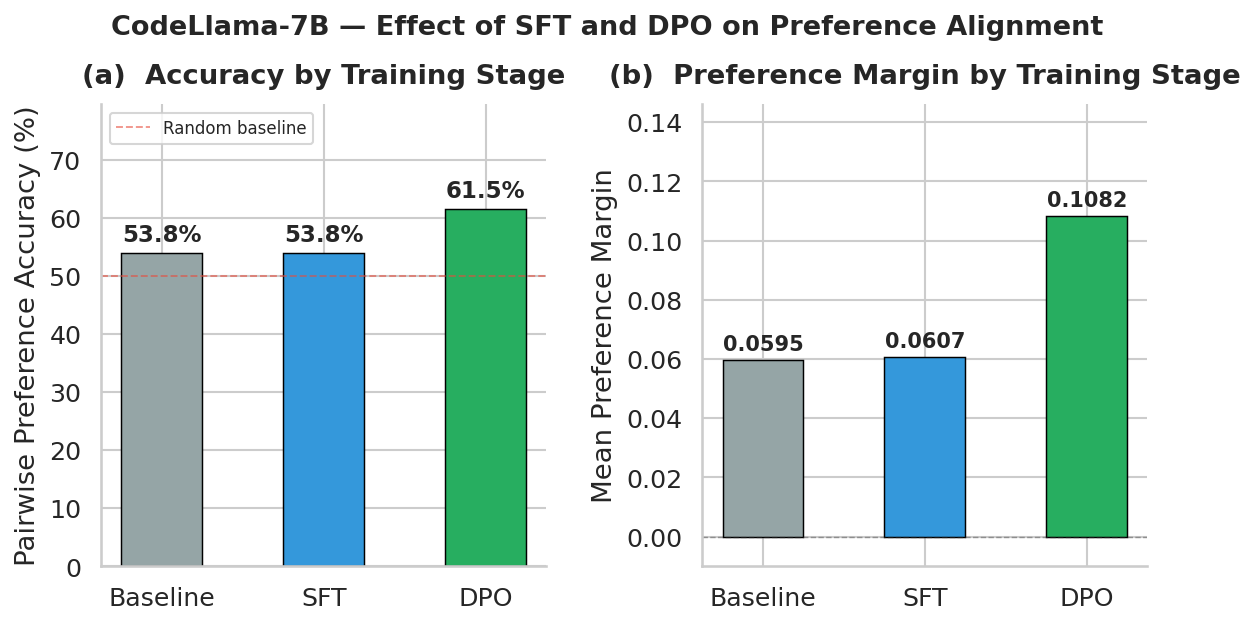

In [10]:
# Figure 1 — Stage Comparison: Accuracy + Preference Margin
stages = [k for k in ["Baseline", "SFT", "DPO"] if results.get(k) is not None]
accs   = [results[s] * 100 for s in stages]
mars   = [all_margins[s] for s in stages]
colors = [_PAL[s] for s in stages]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"wspace": 0.35})

# Left — accuracy
bars1 = ax1.bar(stages, accs, color=colors, edgecolor="black", lw=0.7, width=0.5)
for bar, a in zip(bars1, accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.2,
             f"{a:.1f}%", ha="center", va="bottom", fontweight="bold", fontsize=11)
ax1.axhline(50, ls="--", color="#e74c3c", lw=0.9, alpha=0.6, label="Random baseline")
ax1.set_ylabel("Pairwise Preference Accuracy (%)")
ax1.set_title("(a)  Accuracy by Training Stage", fontweight="bold", pad=10)
ax1.set_ylim(0, max(accs) + 18)
ax1.legend(loc="upper left", fontsize=8)

# Right — margin
bars2 = ax2.bar(stages, mars, color=colors, edgecolor="black", lw=0.7, width=0.5)
for bar, m in zip(bars2, mars):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f"{m:.4f}", ha="center", va="bottom", fontweight="bold", fontsize=10)
ax2.axhline(0, ls="--", color="#333", lw=0.7, alpha=0.4)
ax2.set_ylabel("Mean Preference Margin")
ax2.set_title("(b)  Preference Margin by Training Stage", fontweight="bold", pad=10)
y_pad = max(abs(min(mars)), max(mars)) * 0.35
ax2.set_ylim(min(min(mars) - y_pad, -0.01), max(mars) + y_pad)

fig.suptitle("CodeLlama-7B — Effect of SFT and DPO on Preference Alignment",
             fontweight="bold", fontsize=13, y=1.03)
plt.tight_layout()
for ext in ("pdf", "png"): fig.savefig(FIGURE_DIR / f"fig1_stage_comparison.{ext}")
plt.show()

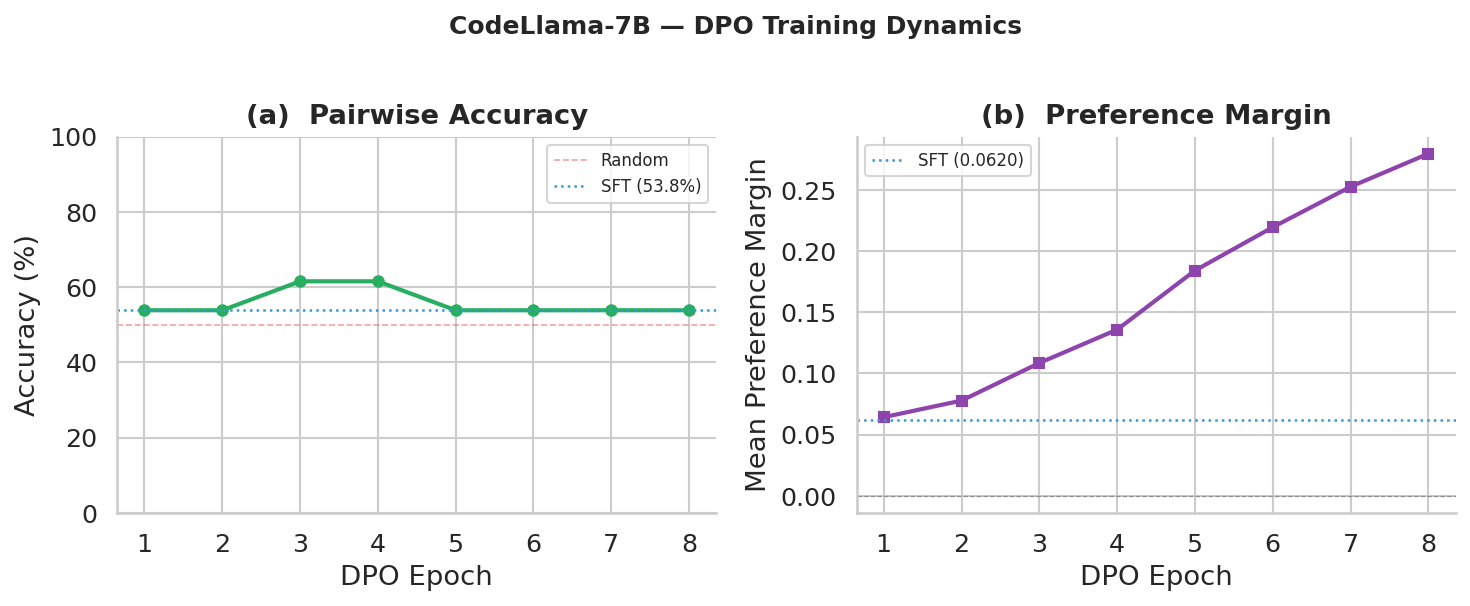

In [11]:
# Figure 2 — DPO Training Dynamics
if epoch_log:
    df_log = pd.DataFrame(epoch_log)
    epochs     = df_log["epoch"].values
    means      = df_log["acc"].values * 100
    ep_margins = df_log["margin"].values

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # (a) Accuracy over epochs
    ax.plot(epochs, means, "o-", color="#27ae60", lw=2, ms=5)
    ax.axhline(50, ls="--", color="#e74c3c", lw=0.8, alpha=0.5, label="Random")
    if sft_baseline is not None:
        ax.axhline(sft_baseline * 100, ls=":", color="#3498db", lw=1.2,
                   label=f"SFT ({sft_baseline*100:.1f}%)")
    ax.set_xlabel("DPO Epoch"); ax.set_ylabel("Accuracy (%)")
    ax.set_title("(a)  Pairwise Accuracy", fontweight="bold")
    ax.legend(fontsize=8); ax.set_ylim(0, 100); ax.set_xticks(epochs)

    # (b) Margin over epochs
    ax2.plot(epochs, ep_margins, "s-", color="#8e44ad", lw=2, ms=5)
    ax2.axhline(0, ls="--", color="#333", lw=0.6, alpha=0.4)
    if sft_bl_margin is not None:
        ax2.axhline(sft_bl_margin, ls=":", color="#3498db", lw=1.2,
                    label=f"SFT ({sft_bl_margin:.4f})")
    ax2.set_xlabel("DPO Epoch"); ax2.set_ylabel("Mean Preference Margin")
    ax2.set_title("(b)  Preference Margin", fontweight="bold")
    ax2.legend(fontsize=8); ax2.set_xticks(epochs)

    fig.suptitle("CodeLlama-7B — DPO Training Dynamics",
                 fontweight="bold", fontsize=12, y=1.01)
    plt.tight_layout()
    for ext in ("pdf", "png"): fig.savefig(FIGURE_DIR / f"fig2_dpo_training.{ext}")
    plt.show()
else:
    print("No epoch log — Figure 2 skipped")


## Summary

| Stage | Method | Description |
|-------|--------|-------------|
| Baseline | Baseline | Pretrained CodeLlama-7B, no preference signal |
| Stage 1 | SFT | Supervised fine-tuning on highest-scored analysis |
| Stage 2 | DPO | Direct preference optimisation on pairwise preferences |

| Figure | File | Content |
|--------|------|---------|
| Fig 1 | `fig1_stage_comparison.pdf` | Accuracy + margin comparison across all stages |
| Fig 2 | `fig2_dpo_training.pdf` | Per-epoch accuracy and margin during DPO training |

**Reproducibility:** H100 80 GB, TF32 enabled, `SAMPLE_SIZE = None`, `EVAL_PASSES = 5`.

In [12]:
export = {
    "model_name": "CodeLlama-7B",
    "model_id": MODEL_NAME,
    "results": dict(results),
    "margins": dict(all_margins),
    "epoch_log": [{"epoch": e["epoch"], "acc": e["acc"], "margin": e["margin"],
                   "pass_accs": e["pass_accs"], "time_min": e["time_min"]}
                  for e in epoch_log] if epoch_log else [],
    "config": {"sft_epochs": SFT_EPOCHS, "dpo_epochs": DPO_EPOCHS,
               "batch_size": BATCH_SIZE, "max_seq_length": MAX_SEQ_LENGTH,
               "sample_size": SAMPLE_SIZE, "eval_passes": EVAL_PASSES},
}

out_path = Path("outputs/results_codellama_7b.json")
out_path.parent.mkdir(exist_ok=True)
with open(out_path, "w") as f:
    json.dump(export, f, indent=2)

print(f"Exported → {out_path}")
for k, v in results.items():
    acc_str = f"{v*100:.2f}%" if v is not None else "N/A"
    mar_str = f"{all_margins[k]:.4f}" if k in all_margins else "N/A"
    print(f"  {k}: acc={acc_str}  margin={mar_str}")

Exported → outputs/results_codellama_7b.json
  Baseline: acc=53.85%  margin=0.0595
  SFT: acc=53.85%  margin=0.0607
  DPO: acc=61.54%  margin=0.1082
